In [22]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.stats import norm

from random_test_matrix import poly_decay, N_random_test_matrices
from randomized_svd import rsvd
from colors import colors3

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 13

In [ ]:
def tsvd(A, k) -> tuple[np.ndarray, float]:
    """
    Get the rank-k truncated matrix Ak of a matrix A using SVD and the
    computation time of the factorization.
    """
    start = time.perf_counter()
    U, S, VT = sp.linalg.svd(A, full_matrices=False, lapack_driver="gesdd")
    end =  time.perf_counter()
    return U[:, :k] @ np.diag(S[:k]) @ VT[:k, :], end - start


def trsvd(A, k, p) -> tuple[np.ndarray, float]:
    """
    Get the rank-k truncated matrix Ak of a matrix A using
    randomized SVD with oversampling parameter p and the computation time
    of the factorization.
    """
    start = time.perf_counter()
    Uk, Sk, VkT = rsvd(A, k, p)
    end =  time.perf_counter()
    return Uk @ np.diag(Sk) @ VkT, end - start


def gamma(k, p, m, n):
    """
    Compute the coefficient for the expected error for RSVD.
    """
    return 1 + 4 * np.sqrt(k + p) / (p - 1) * np.sqrt(min(m, n))


def errors_rsvd_expected(singular_values, k_min, k_max, p):
    k_range = np.arange(k_min, k_max)
    n = len(singular_values)
    gammas = np.array([gamma(k, p, n, n) for k in k_range])
    return gammas * singular_values[k_min:k_max]


def errors_mean_ci(errors, nk, p=99):
    """
    Given errors of shape (3, r, nk), where r is the number of repeats and nk the
    number of k's, compute the mean and p% confidence intervals.
    """
    mean = errors.mean(axis=1)

    # Calculate p% confidence intervals
    std = errors.std(axis=1)
    z = norm.ppf((1 + p / 100) / 2)
    ci = z * std / np.sqrt(nk)
    return mean, ci


def progress_bar(step, total_steps, bar_length=30, fill='#', end_text=''):
    """
    Simple progress bar.
    """
    
    filled = int(bar_length * step / total_steps)
    text = f"[{filled * fill :<{bar_length}}] {step}/{total_steps}"
    end = '\r' if step < total_steps else '\n\n' 
    print(text + end_text, end=end)


def experiment(AN, k_min, k_max, p=5):
    """
    Construct matrices with the given singular value distribution, and compute the l2
    errors of the rank-k approximation using randomized SVD with oversampling parameter p.
    """
    k_range = np.arange(k_min, k_max)
    nk = k_max - k_min
    N = AN.shape[0]

    dt_svd = np.zeros((N, nk))
    dt_rsvd = np.zeros((N, nk))
    errors = np.zeros((N, nk))
    for r in range(N):  # For repeat r
        progress_bar(r+1, N)
        A = AN[r, :, :]
        for i, k in enumerate(k_range):
            Ak, t_rsvd = trsvd(A, k, p)
            _, t_svd = tsvd(A, k)

            dt_rsvd[r, i] = t_rsvd
            dt_svd[r, i] = t_svd
            errors[r, i] = np.linalg.norm(A - Ak, 2)
    return {
        "errors": errors,
        "dt rsvd": dt_rsvd,
        "dt svd": dt_svd
    }

Expected error for a rank-$k$ reconstruction using RSVD
$$
\begin{aligned}
&\mathbb{E}\|A - QQ^TA\| \le \gamma\sigma_{k+1}\\
&\gamma = \left[
1 + \frac{4\sqrt{k+p}}{p-1}\sqrt{\min\{m,n\}}
\right]
\end{aligned}
$$
Synthetic decay of singular values
$$
\sigma_{k+1} = \frac{C}{(1 + \alpha k)^q},\space k=0,\dots,n-1
$$
$$
100 \times 5000
$$

In [33]:
# Generate spectral decays
C, q = 10, 2
m, n = 100, 1000
alphas = np.array([0.01, 0.1, 0.5])
Ss = np.array([poly_decay(min(m, n), C, alpha, q) for alpha in alphas])

# Generate the data
repeats = 10
AN = [N_random_test_matrices(repeats, m, n, s) for s in Ss]

# Perform the experiments
p = 10                # Oversampling
k_min, k_max = 5, 45  # Rank range
experiments = [experiment(AN[i], k_min, k_max, p) for i in range(3)]  # 3 experiments

# Extract data
errors = np.array([e['errors'] for e in experiments])
dt_rsvd = np.array([e['dt rsvd'] for e in experiments])
dt_svd = np.array([e['dt svd'] for e in experiments])
expected_errors = np.array([
    errors_rsvd_expected(S, k_min, k_max, p)
    for S in Ss
])

[##############################] 10/10

[##############################] 10/10

[##############################] 10/10



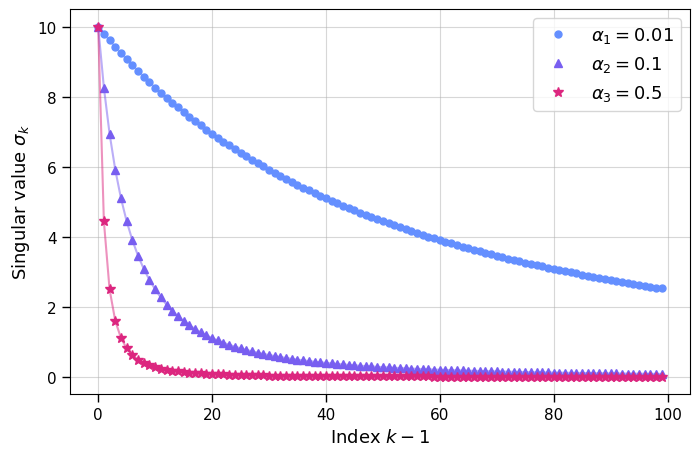

In [42]:
styles = ['-', '--', '-.']
markers = ['o', '^', '*']
sizes = [5, 6, 7]

nk = k_max - k_min
k_range = np.arange(k_min, k_max)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(len(Ss)):
    ax.plot(np.arange(min(m, n)), Ss[i], markers[i],
            c=colors3[i], ms=sizes[i], label=f'$\\alpha_{i+1}={alphas[i]}$')
    ax.plot(np.arange(min(m, n)), Ss[i], '-', c=colors3[i], ms=1, alpha=0.5)

ax.set_xlabel('Index $k-1$', fontsize=13)
ax.set_ylabel('Singular value $\\sigma_k$', fontsize=13)

ax.tick_params(axis='both', which='major', labelsize=11, length=6, width=1)
ax.tick_params(axis='both', which='minor', length=3, color='gray')

ax.grid(True, alpha=0.5)
ax.legend()

plt.savefig("../figures/singular_value_decay.png", dpi=300)
plt.show()

[]

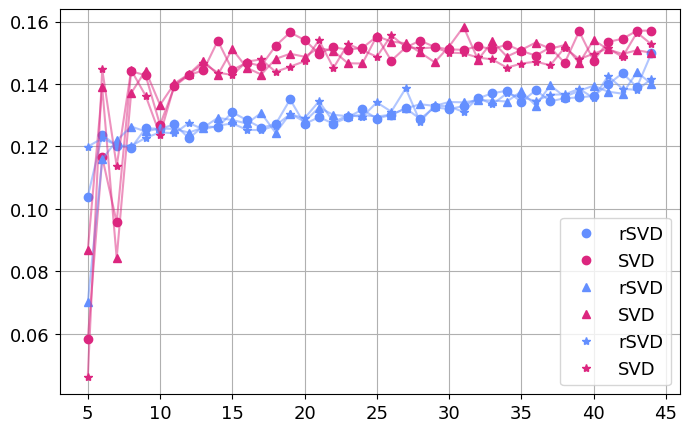

In [72]:
# Calculate the mean, std and ci for each experiment
median_rsvd = np.median(dt_rsvd, axis=1)
median_svd = np.median(dt_svd, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i in range(3):
    ax.plot(k_range, median_rsvd[i], markers[i], c=colors3[0], label='rSVD')
    ax.plot(k_range, median_rsvd[i], c=colors3[0], alpha=0.5)
    ax.plot(k_range, median_svd[i], markers[i], c=colors3[2], label='SVD')
    ax.plot(k_range, median_svd[i], c=colors3[2], alpha=0.5)

ax.grid(True)
ax.legend()
plt.plot()

[]

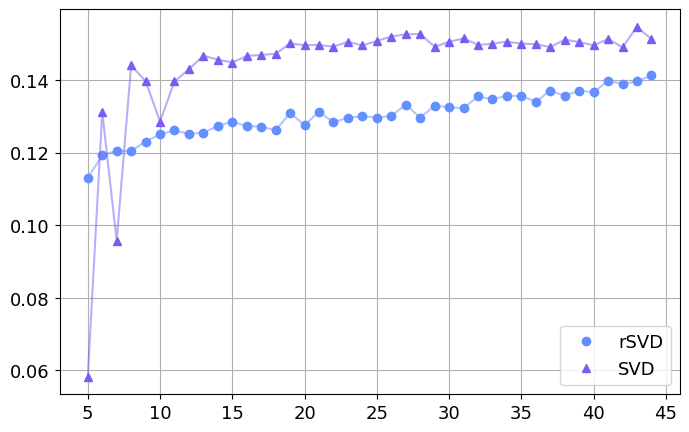

In [74]:
# Calculate the mean, std and ci for each experiment
median_rsvd = np.median(dt_rsvd, axis=(0, 1))
median_svd = np.median(dt_svd, axis=(0, 1))

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(k_range, median_rsvd, markers[0], c=colors3[0], label='rSVD')
ax.plot(k_range, median_rsvd, c=colors3[0], alpha=0.5)
ax.plot(k_range, median_svd, markers[1], c=colors3[1], label='SVD')
ax.plot(k_range, median_svd, c=colors3[1], alpha=0.5)

ax.grid(True)
ax.legend()
plt.plot()

In [7]:
mean, ci = errors_mean_ci(errors, k_max-k_min, p=99)

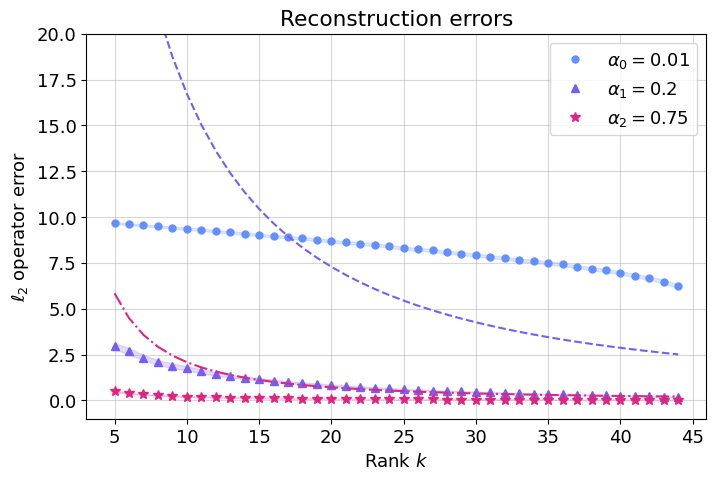

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(3):
    ax.plot(k_range, mean[i], markers[i], c=colors3[i], ms=sizes[i],
            label=f'$\\alpha_{i}={alphas[i]}$')
    ax.plot(k_range, expected_errors[i], c=colors3[i], ls=styles[i])
    #ax.plot(k_range, mean_error, color=colors3[i], lw=2, alpha=0.5)
    ax.fill_between(k_range, mean[i] - ci[i], mean[i]+ ci[i], color=colors3[i], alpha=0.2)


ax.set_ylim(-1, 20)
ax.set_xlabel('Rank $k$')
ax.set_ylabel('$\\ell_2$ operator error')
ax.set_title('Reconstruction errors')
ax.legend()
ax.grid(True, alpha=0.5)
plt.show()

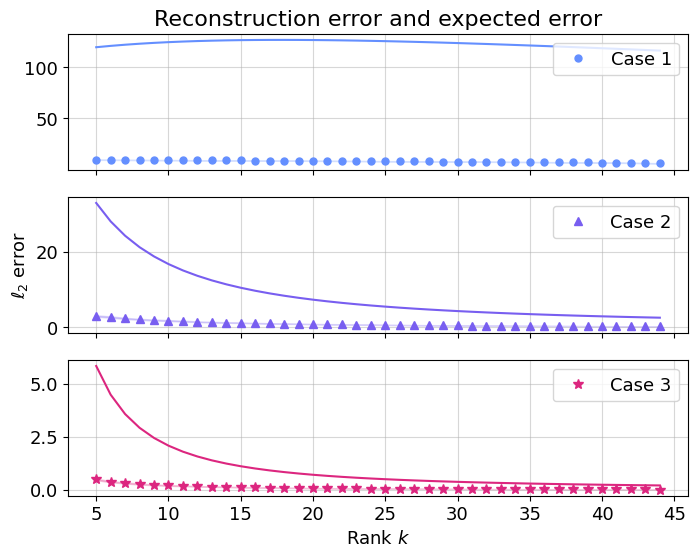

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

k_range = np.arange(k_min, k_max)

for i in range(3):
    ax = axs[i]
    ax.plot(k_range, mean[i], markers[i], c=colors3[i], ms=sizes[i], label=f'Case {i + 1}')
    ax.plot(k_range, expected_errors[i], c=colors3[i])
    ax.fill_between(k_range, mean[i] - ci[i], mean[i]+ ci[i], color=colors3[i], alpha=0.25)

    ax.grid(True, alpha=0.5)
    ax.legend(loc='upper right')

axs[0].set_title("Reconstruction error and expected error", fontsize=16)
axs[1].set_ylabel('$\\ell_2$ error', fontsize=13)
axs[2].set_xlabel("Rank $k$", fontsize=13)

plt.show()

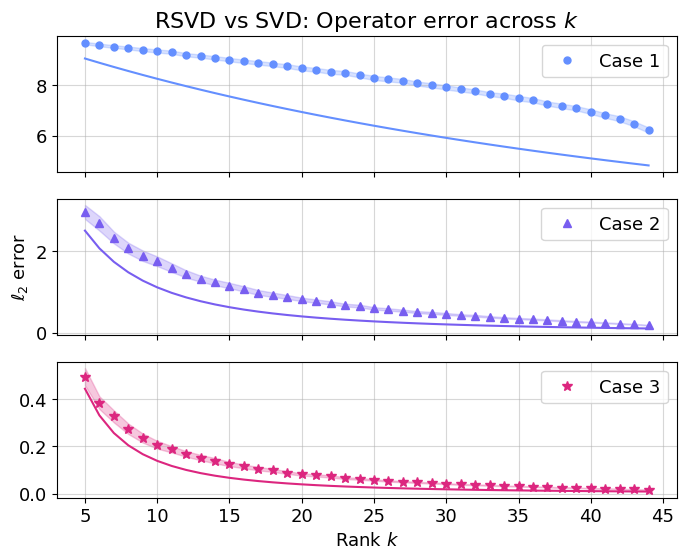

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

k_range = np.arange(k_min, k_max)

for i in range(3):
    ax = axs[i]
    ax.plot(k_range, mean[i], markers[i], c=colors3[i], ms=sizes[i], label=f'Case {i + 1}')  # RSVD error
    ax.plot(k_range, Ss[i][k_range], c=colors3[i])  # SVD error
    ax.fill_between(k_range, mean[i] - ci[i], mean[i]+ ci[i], color=colors3[i], alpha=0.25)
    ax.grid(True, alpha=0.5)
    ax.legend()

axs[0].set_title("RSVD vs SVD: Operator error across $k$", fontsize=16)
axs[1].set_ylabel('$\\ell_2$ error', fontsize=13)
axs[2].set_xlabel("Rank $k$", fontsize=13)

plt.show()